## Attention scores

What relationships exists between pairwise attention scores and pairwise distances?

In [1]:
import sys
sys.path.append('..')

import os
import random

import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from models.biased_attention_transformer import BiasedAttentionTransformer
from data import PointCloudDataset

%load_ext autoreload
%autoreload 2

In [33]:
model = BiasedAttentionTransformer(
    n_tokens=6, 
    out_features=3, 
    E=64, H=8, D=8, 
    dropout=0.1, 
    radial_function_type="PowerLaw"
)
model_file = "/scratch/midway3/jshe/molecular-attention-bias/homo_lumo_U/BiasedAttentionTransformer/PowerLaw/E64H8D8/202508151721234/model.pt"
state_dict = torch.load(model_file, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval();

In [34]:
dataset = PointCloudDataset(
    data_dir = "/scratch/midway3/jshe/data/qm9/scaffolded/validation/", 
    target_labels = ['U', 'G']
)
dataloader = DataLoader(
    dataset, batch_size=64, shuffle=True, 
    num_workers=4, persistent_workers=True, pin_memory=True, 
    collate_fn=dataset.collate
)


In [35]:
tokens, padding, r, y = next(iter(dataloader))
B, L, _ = r.shape
model(tokens, padding, r, hook=True);

/scratch/midway3/jshe/.conda/envs/moltorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [36]:
d = torch.norm(
    r.unsqueeze(1) - r.unsqueeze(2), 
    dim=-1
).reshape(B, L, L).log()

In [39]:

d = torch.norm(
    r.unsqueeze(1) - r.unsqueeze(2), 
    dim=-1
).unsqueeze(1).expand(B, 8, L, L)
mask = torch.logical_and(d != 0, d < 1e8)
d = d[mask]

indices = torch.tensor(random.sample(range(len(d)), 512))
sample_d = d[indices]

## Attention Logits

In [58]:
layer = 1

qkt = model.transformer_blocks[layer].attn.hook['qkt']
qkt = qkt[mask]
sample_qkt = qkt[indices].numpy()

attn_bias = model.transformer_blocks[layer].attn.hook['attn_bias']
attn_bias = attn_bias[mask]
sample_attn_bias = attn_bias[indices].numpy()

attn_logits = model.transformer_blocks[layer].attn.hook['attn_logits']
attn_logits = attn_logits[mask]
sample_attn_logits = attn_logits[indices]

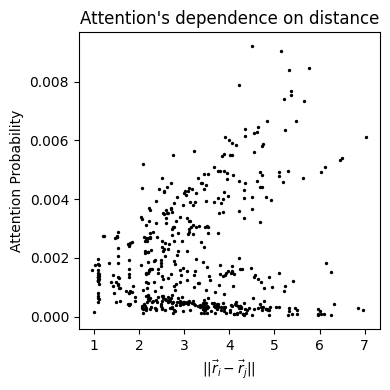

In [59]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(sample_d, torch.nn.functional.softmax(sample_attn_logits, dim=-1), s=2, color='k')
ax.set_xlabel(r'$|| \vec{r}_i - \vec{r}_j ||$')
ax.set_ylabel(r'Attention Probability')
ax.set_title('Attention\'s dependence on distance')
fig.tight_layout()

Text(0.5, 1.0, '$\\tilde{a}_{ij}$')

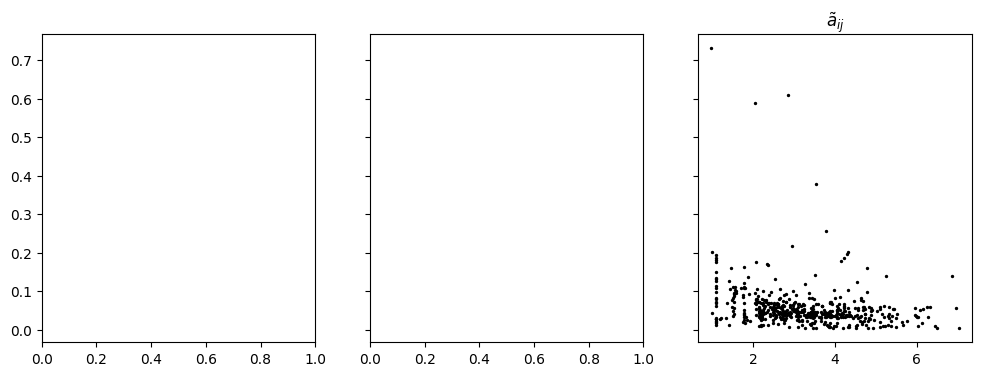

In [41]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

#ax0.scatter(sample_d, sample_qkt, s=2, color='k')
#ax0.set_title('$QK^T$')
#ax1.scatter(sample_d, sample_attn_bias, s=2, color='k')
#ax1.set_title('$b_{ij}$')
ax2.scatter(sample_d, sample_attn_logits, s=2, color='k')
ax2.set_title(r'$\tilde{a}_{ij}$')